In [14]:
from importlib import reload 

In [21]:
import coNLL.conll as co

In [75]:
reload(co)

<module 'coNLL.conll' from '/Users/danilculkov/Desktop/Учеба/Кафедра/2020/I-want-to-learn-NLP/CoNLL-model/coNLL/conll.py'>

In [76]:
conll = co.CoNLL('./coNLL/')

In [77]:
for typ in conll.types:
    conll.split_text_label(typ)

[['EU', 'B-ORG'], ['rejects', 'O'], ['German', 'B-MISC'], ['call', 'O'], ['to', 'O'], ['boycott', 'O'], ['British', 'B-MISC'], ['lamb', 'O'], ['.', 'O']]
[['CRICKET', 'O'], ['-', 'O'], ['LEICESTERSHIRE', 'B-ORG'], ['TAKE', 'O'], ['OVER', 'O'], ['AT', 'O'], ['TOP', 'O'], ['AFTER', 'O'], ['INNINGS', 'O'], ['VICTORY', 'O'], ['.', 'O']]
[['SOCCER', 'O'], ['-', 'O'], ['JAPAN', 'B-LOC'], ['GET', 'O'], ['LUCKY', 'O'], ['WIN', 'O'], [',', 'O'], ['CHINA', 'B-PER'], ['IN', 'O'], ['SURPRISE', 'O'], ['DEFEAT', 'O'], ['.', 'O']]


In [79]:
conll.create_tag2idx('./coNLL/tag2idx.json')
conll.create_idx2tag()

In [80]:
conll.create_one_labeled_data('train')

## Preprocessing

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


Let's prepare the data for the input of BERT tokenizer.

In [3]:
def split_text_label(filename):
    f = open(filename)
    split_labeled_text = []
    sentence = []
    for line in f:
        if len(line)==0 or line.startswith('-DOCSTART') or line[0]=="\n":
            if len(sentence) > 0:
                split_labeled_text.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0],splits[-1].rstrip("\n")])
    if len(sentence) > 0:
        split_labeled_text.append(sentence)
        sentence = []
    sentences = []
    labels = []
    for sent in split_labeled_text:
        sentence = []
        label = []
        for s_l in sent:
            sentence.append(s_l[0])
            label.append(s_l[1])
        sentences.append(sentence)
        labels.append(label)
    return sentences, labels

In [4]:
train_data, train_labels = split_text_label("coNLL/train.txt")
valid_data, valid_labels = split_text_label("coNLL/valid.txt")
test_data, test_labels = split_text_label("coNLL/test.txt")

In [5]:
# the first sentence
train_data[0]

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']

In [6]:
# its tokens
train_labels[0]

['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']

Lets create tag dictionary

In [7]:
tag_values = set()
for l in train_labels:
    tag_values.update(l)
tag_values.update(["PAD"])
tag2idx = {t: i for i, t in enumerate(tag_values)}

In [8]:
tag2idx

{'PAD': 0,
 'I-PER': 1,
 'B-ORG': 2,
 'I-MISC': 3,
 'B-PER': 4,
 'B-LOC': 5,
 'O': 6,
 'I-LOC': 7,
 'I-ORG': 8,
 'B-MISC': 9}

In [9]:
idx2tag = {v: k for k, v in tag2idx.items()}

### Tokenization with BertTokenizer

BERT (Bidirectional Encoder Representations from Transformers) is a method of pretraining language representations. These vectors (representations) are used as high-quality feature inputs to downstream models. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them.

In [9]:
#!pip install transformers

     |████████████████████████████████| 1.4MB 10.6MB/s 
     |████████████████████████████████| 2.9MB 40.7MB/s 
     |████████████████████████████████| 890kB 45.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=59e8b106c7c0f5ce163cb71e89613d25b38cb4db54b7336164795683cbd91dec
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel
from keras.preprocessing.sequence import pad_sequences

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

The Bert implementation comes with a pretrained tokenizer and a definied vocabulary. We load the one related to the smallest pre-trained model bert-base-cased. We use the cased variate since it is well suited for NER.

In [10]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [11]:
def tokenize_and_preserve_labels(sentence, text_labels, tokenizer):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return ['[CLS]'] + tokenized_sentence + ['[SEP]'], ['O'] + labels + ['O']

In [12]:
train_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(train_data, train_labels)]
valid_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(valid_data, valid_labels)]
test_tokenized = [tokenize_and_preserve_labels(s, l, tokenizer) for s, l in zip(test_data, test_labels)]

In [13]:
train_tokens = [x[0] for x in train_tokenized]
train_labels = [x[1] for x in train_tokenized]
valid_tokens = [x[0] for x in valid_tokenized]
valid_labels = [x[1] for x in valid_tokenized]
test_tokens = [x[0] for x in test_tokenized]
test_labels = [x[1] for x in test_tokenized]

In [36]:
MAX_SEQ_LENGTH = np.max([len(sen) for sen in train_tokens])
        
MEAN_SEQ_LENGTH = int(np.mean([len(sen) for sen in train_tokens]))

In [42]:
print(MAX_SEQ_LENGTH)
print(MEAN_SEQ_LENGTH)

173
21


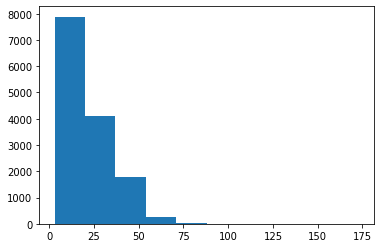

In [41]:
plt.hist([len(sen) for sen in train_tokens])
plt.show()

In [43]:
np.quantile([len(sen) for sen in train_tokens], 0.75)

30.0

Next, we cut and pad the token and label sequences to our desired length. Let's constaint sequence length with 0.75 quantile - 30 tokens.

In [82]:
#DISIRED_LENGTH = int(np.quantile([len(sen) for sen in train_tokens], 0.75))
DISIRED_LENGTH = MAX_SEQ_LENGTH

In [83]:
train_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in train_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
train_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in train_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
valid_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in valid_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
valid_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in valid_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
test_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in test_tokens],
                          maxlen=DISIRED_LENGTH, dtype="long", value=0.0,
                          truncating="post", padding="post")
test_tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in test_labels],
                     maxlen=DISIRED_LENGTH, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [84]:
# the first train sentence
train_ids[0]

array([  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495,
       12913,   119,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

We create the masks to ignore the padded elements in the sequences.

In [85]:
train_masks = [[float(i != 0.0) for i in ii] for ii in train_ids]
valid_masks = [[float(i != 0.0) for i in ii] for ii in valid_ids]
test_masks = [[float(i != 0.0) for i in ii] for ii in test_ids]

We have to convert the dataset to torch tensors.

In [86]:
train_inputs = torch.tensor(train_ids)
train_tags = torch.tensor(train_tags)
train_masks = torch.tensor(train_masks)
valid_inputs = torch.tensor(valid_ids)
valid_tags = torch.tensor(valid_tags)
valid_masks = torch.tensor(valid_masks)
test_inputs = torch.tensor(test_ids)
test_tags = torch.tensor(test_tags)
test_masks = torch.tensor(test_masks)

The last step is to define the dataloaders. We shuffle the data at training time with the RandomSampler and at test time we just pass them sequentially with the SequentialSampler.

In [154]:
# let's set the batch size
BATCH_SIZE = 512

In [155]:
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

valid_data = TensorDataset(valid_inputs, valid_masks, valid_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=BATCH_SIZE)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

### BERT setup

The transformer package provides a BertForTokenClassification class for token-level predictions. BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

In [23]:
#!pip install pytorch-crf

In [21]:
from transformers import BertForTokenClassification, AdamW
from torch import nn
from torchcrf import CRF

In [101]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [22]:
# Bert pre-trained model selected in the list: bert-base-uncased, 
# bert-large-uncased, bert-base-cased, bert-large-cased, bert-base-multilingual-uncased,
# bert-base-multilingual-cased, bert-base-chinese.
BERT_MODEL = 'bert-base-cased'

# The name of the task to train.I'm going to name this 'yelp'.
TASK_NAME = 'first'

# The output directory where the fine-tuned model and checkpoints will be written.
OUTPUT_DIR = f'outputs/{TASK_NAME}/'

# The directory where the evaluation reports will be written to.
REPORTS_DIR = f'reports/{TASK_NAME}_evaluation_report/'


# This is where BERT will look for pre-trained models to load parameters from.
CACHE_DIR = 'cache/'

In [139]:
class Our_model(nn.Module):
    """
    BERT+biLSTM+Linear+Relu
    """
    def __init__(self, hidden_size=128, num_labels=len(tag2idx), bert_layers=1, concat=True):
        """
        Creates model
        
        Parameters
        ----------
        batch_size:
        hidden_size:
        num_labels:
        bert_layers: int, default=1
            Num of final BERT hidden layers to be used as embedding vector.
        concat: bool, default=True
            Whether to concat (True) or sum (False) last BERT hidden layers.
        
        """
        super(Our_model, self).__init__()

        self.hidden_size = hidden_size
        self.num_labels = num_labels
        self.bert_layers = bert_layers
        self.concat = concat
        
        self.bert = BertForTokenClassification.from_pretrained(
                        BERT_MODEL, #cache_dir=CACHE_DIR,
                        output_hidden_states=True)
        
        for pars in self.bert.parameters():
            pars.requires_grad = False
        
        embedding_dim = self.bert.config.to_dict()['hidden_size']
        
        if self.concat:
            self.bilstm = nn.LSTM(embedding_dim*self.bert_layers, self.hidden_size,
                                  bidirectional=True)
        else:
            self.bilstm = nn.LSTM(embedding_dim, self.hidden_size,
                                  bidirectional=True)
        
        self.linear = nn.Linear(self.hidden_size*2, self.num_labels)
        self.crf = CRF(num_tags=self.num_labels, batch_first=True)
    
    def forward(self, sequence, attention_mask):
        """
        Forward propogate of model.
        
        Parameters
        ----------
        sequence:
        attention_mask:
        
        Returns
        -------
        Logits
        
        """

        bert_hiddens = self.bert(sequence, attention_mask=attention_mask)[1]
        if self.concat:
            bert_embedding = torch.cat(bert_hiddens[-self.bert_layers:], dim=2)#[bert_hiddens[-i] for i in range(-1, -self.bert_layers-1, -1)], dim=0)
        else:
            emb_sum = 0
            for h in bert_hiddens[-self.bert_layers:]:
                emb_sum += h
            bert_embedding = emb_sum
    
        bilstm_output, (h_n, c_n) = self.bilstm(bert_embedding)
        linear_output = nn.functional.relu(self.linear(bilstm_output))
        return linear_output

If we need scheduler

In [30]:
#from transformers import get_linear_schedule_with_warmup

In [ ]:
#total_steps = len(train_dataloader) * NUM_TRAIN_EPOCHS

#scheduler = get_linear_schedule_with_warmup(
#    optimizer,
#    num_warmup_steps=0,
#    num_training_steps=total_steps
#)

Let's use seqeval library for sequence labeling evaluation

In [29]:
#!pip install seqeval

     |████████████████████████████████| 51kB 3.8MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp36-none-any.whl size=16171 sha256=4e941855eef92f8adb3154eb72a82e7f3b2d85bcb40a2854ed9c454a7bba0b8e
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [25]:
import tqdm
from seqeval.metrics import f1_score, accuracy_score

In [165]:
def train(model, train_dataloader, optimizer, scheduler=None, n_epoch=5,
          max_grad_norm=None, validate=True, valid_dataloader=None,
          show_info=True):
    loss_values = []
    if validate and valid_dataloader is not None:
        validation_loss_values = []
        valid_accuracies = []
        valid_f1_scores = []

    for _ in range(n_epoch):
    
        # Training

        model.train()

        total_loss = 0

        if show_info:
            enumerator = enumerate(tqdm.tqdm(train_dataloader, position=0, leave=True))
        else:
            enumerator = enumerate(train_dataloader)

        for step, batch in enumerator:
            if device.type != 'cpu':
                batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            model.zero_grad()

            logits = model.forward(b_input_ids, b_input_mask.byte())
            
            # because we need negative log likelyhood
            loss = -1*model.crf.forward(logits, b_labels, mask=b_input_mask.byte())

            loss.backward()

            total_loss += loss.item()

            if show_info:
                if step % 4 == 0 and step > 0:
                    print(f"\n{step}: avg loss per batch: {total_loss/step}\n")

            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
                                            max_norm=max_grad_norm)

            optimizer.step()

            if scheduler is not None:
                scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        if show_info:
            print(f"Average train loss: {avg_train_loss}")

        loss_values.append(avg_train_loss)

        if validate and valid_dataloader is not None:
          # Validation

            model.eval()

            eval_loss, eval_accuracy = 0, 0
            predictions, true_labels = [], []

            for batch in valid_dataloader:
                if device.type != 'cpu':
                    batch = tuple(t.to(device) for t in batch)
                b_input_ids, b_input_mask, b_labels = batch

                with torch.no_grad():
                    logits = model.forward(b_input_ids, b_input_mask.byte())
                    loss = -1*model.crf.forward(logits, b_labels, mask=b_input_mask.byte())
                    tags = model.crf.decode(logits, mask=b_input_mask.byte())

                # move loss to cpu
                eval_loss += loss.item()
                predictions.extend(tags)
                labels_ = b_labels.detach().cpu().numpy()
                true_labels.extend(labels_)

            eval_loss = eval_loss / len(valid_dataloader)
            validation_loss_values.append(eval_loss)
            if show_info:
                print(f"Validation loss: {eval_loss}")

            all_predicted_tags = []
            for s in predictions:
                tag_names = [idx2tag[i] for i in s]
                all_predicted_tags.append(tag_names)

            all_true_tags = []
            for s in true_labels:
                tag_names = [idx2tag[i] for i in s if idx2tag[i] != 'PAD']
                all_true_tags.append(tag_names)

            valid_acc = accuracy_score(all_predicted_tags, all_true_tags)
            valid_f1 = f1_score(all_predicted_tags, all_true_tags)
            valid_accuracies.append(valid_acc)
            valid_f1_scores.append(valid_f1)

            if show_info:
                print(f"Validation accuracy: {valid_acc}")
                print(f"Validation F1-score: {valid_f1}\n")

    return loss_values, validation_loss_values, valid_accuracies, valid_f1_scores

In [53]:
from sklearn.model_selection import KFold, ParameterGrid
import numpy as np

Fix some train parameters


In [54]:
NUM_TRAIN_EPOCHS = 2

RANDOM_SEED = 42

N_FOLDS = 3

N_EPOCHS = 1

In [55]:
kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
# model = Our_model(batch_size=BATCH_SIZE, hidden_size=128, num_labels=len(tag2idx),
#                     bert_layers=2, concat=False)
# model.to(device)

In [ ]:
# opt = AdamW(params=model.parameters(),lr=1e-3)
# train(model, train_dataloader, opt)

For parameteres search let's leave just 1/5 of training examples (~2800).

In [97]:
small_train_indexes = np.random.randint(0, len(train_data), int(len(train_data)/5))

In [98]:
small_train = torch.utils.data.Subset(train_data, small_train_indexes)

In [113]:
%time
param_grid = {
    'opt': ['AdamW'],
    'lr': [3e-4, 7e-4, 1e-3],
    'bert_layers': [2,3],
    'concat': [True, False],
    'max_grad_norm': [None]#[1., None]
}

#param_grid = {
#    'opt': ['AdamW'],
#    'lr': [1e-3],
#    'bert_layers': [2],
#    'concat': [False],
#    'max_grad_norm': [None]
#}

grid = ParameterGrid(param_grid)

params_results = {}

for m, ps in enumerate(grid):
    print(f"Model #{m} of {len(grid)}")
    _p_r = {'params': ps}

    mean_train_losses = 0
    mean_valid_losses = 0
    mean_valid_accs = 0
    mean_valid_f1s = 0

    for i, (train_index, valid_index) in enumerate(kf.split(small_train)):
        train_fold = torch.utils.data.Subset(train_data, train_index)
        valid_fold = torch.utils.data.Subset(train_data, valid_index)
        _train_dataloader = DataLoader(train_fold, batch_size=BATCH_SIZE)
        _valid_dataloader = DataLoader(valid_fold, batch_size=BATCH_SIZE)

        model = Our_model(hidden_size=128, 
                          bert_layers=ps['bert_layers'],
                          concat=ps['concat'])
        if device.type != 'cpu':
            model.to(device)

        if ps['opt'] == 'Adam':
            optimizer = torch.optim.Adam(params=model.parameters(),lr=ps['lr'])
        else:
            optimizer = AdamW(params=model.parameters(),lr=ps['lr'])

        train_losses, valid_losses, valid_accs, valid_f1s = train(model,
                                                _train_dataloader,
                                                optimizer,
                                                n_epoch=N_EPOCHS,
                                                max_grad_norm=ps['max_grad_norm'],
                                                valid_dataloader=_valid_dataloader,
                                                show_info=False)
    
        mean_train_losses += np.array(train_losses)
        mean_valid_losses += np.array(valid_losses)
        mean_valid_accs += np.array(valid_accs)
        mean_valid_f1s += np.array(valid_f1s)
  
    mean_train_losses /= N_FOLDS
    mean_valid_losses /= N_FOLDS
    mean_valid_accs /= N_FOLDS
    mean_valid_f1s /= N_FOLDS
    _p_r['mean_train_losses'] = list(mean_train_losses)
    _p_r['mean_valid_losses'] = list(mean_valid_losses)
    _p_r['mean_valid_accs'] = list(mean_valid_accs)
    _p_r['mean_valid_f1s'] = list(mean_valid_f1s)
    params_results[m] = _p_r 

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.72 µs
Model #0 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #1 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #2 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #3 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #4 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #5 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #6 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #7 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #8 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #9 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #10 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

Model #11 of 12


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [114]:
params_results

{0: {'params': {'bert_layers': 2,
   'concat': True,
   'lr': 0.0003,
   'max_grad_norm': None,
   'opt': 'AdamW'},
  'mean_train_losses': [46461.16015625],
  'mean_valid_losses': [42868.494791666664],
  'mean_valid_accs': [0.4307256358067166],
  'mean_valid_f1s': [0.04306148100847803]},
 1: {'params': {'bert_layers': 2,
   'concat': True,
   'lr': 0.0007,
   'max_grad_norm': None,
   'opt': 'AdamW'},
  'mean_train_losses': [44169.748046875],
  'mean_valid_losses': [35965.94140625],
  'mean_valid_accs': [0.7669562096182889],
  'mean_valid_f1s': [0.00021729682746631898]},
 2: {'params': {'bert_layers': 2,
   'concat': True,
   'lr': 0.001,
   'max_grad_norm': None,
   'opt': 'AdamW'},
  'mean_train_losses': [41096.2890625],
  'mean_valid_losses': [28607.479166666668],
  'mean_valid_accs': [0.7670739646750677],
  'mean_valid_f1s': [0.0]},
 3: {'params': {'bert_layers': 2,
   'concat': False,
   'lr': 0.0003,
   'max_grad_norm': None,
   'opt': 'AdamW'},
  'mean_train_losses': [46515.8561

After train on 1 epoch on small dataset the best result gave the model that concatenates two last bert layers and has learning rate 3e-4, so let's train such model on all train data. Also, let's increase LSTM hidden size to be 512 and use now linear scheduler.

In [122]:
N_EPOCHS=5

In [116]:
from transformers import get_linear_schedule_with_warmup

In [156]:
total_steps = len(train_dataloader) *  N_EPOCHS

In [166]:
model = Our_model(hidden_size=512, bert_layers=2)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [168]:
optimizer = AdamW(params=model.parameters(),lr=3e-4)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

if device.type != 'cpu':
    model.to(device)

#train_losses, valid_losses, valid_accs, valid_f1s
results = train(model, train_dataloader, optimizer, scheduler, n_epoch=N_EPOCHS,
     validate=True, valid_dataloader=valid_dataloader)
                                                

 18%|█▊        | 5/28 [09:06<41:45, 108.92s/it]


4: avg loss per batch: 6314.7862548828125



 32%|███▏      | 9/28 [1:26:33<5:09:41, 978.00s/it]


8: avg loss per batch: 5550.369323730469



 46%|████▋     | 13/28 [4:02:17<7:44:43, 1858.92s/it] 


12: avg loss per batch: 5276.091715494792



 61%|██████    | 17/28 [4:11:14<1:40:53, 550.36s/it] 


16: avg loss per batch: 5036.2574462890625



 75%|███████▌  | 21/28 [4:20:11<27:23, 234.74s/it]  


20: avg loss per batch: 4873.363818359375



 89%|████████▉ | 25/28 [4:28:59<07:42, 154.00s/it]


24: avg loss per batch: 4745.4034423828125



100%|██████████| 28/28 [4:34:04<00:00, 587.32s/it]


Average train loss: 4433.7581133161275
Validation loss: 3857.615077427455


  0%|          | 0/28 [00:00<?, ?it/s]

Validation accuracy: 0.8888485923060391
Validation F1-score: 0.507137874912811



 18%|█▊        | 5/28 [09:22<42:58, 112.11s/it]


4: avg loss per batch: 5129.735290527344



 32%|███▏      | 9/28 [1:50:44<6:50:35, 1296.61s/it]


8: avg loss per batch: 4646.592498779297



 46%|████▋     | 13/28 [1:59:03<1:41:29, 405.93s/it]


12: avg loss per batch: 4489.362711588542



 61%|██████    | 17/28 [2:06:48<33:56, 185.15s/it]  


16: avg loss per batch: 4343.702392578125



 75%|███████▌  | 21/28 [2:14:52<15:54, 136.40s/it]


20: avg loss per batch: 4267.050317382813



 89%|████████▉ | 25/28 [2:23:14<06:21, 127.25s/it]


24: avg loss per batch: 4202.575876871745



100%|██████████| 28/28 [2:27:57<00:00, 317.06s/it]


Average train loss: 3949.8855503627233
Validation loss: 3600.4528459821427


  0%|          | 0/28 [00:00<?, ?it/s]

Validation accuracy: 0.8914275736084246
Validation F1-score: 0.5186604617209598



 18%|█▊        | 5/28 [09:32<44:26, 115.92s/it]


4: avg loss per batch: 4816.748107910156



 32%|███▏      | 9/28 [17:06<36:11, 114.31s/it]


8: avg loss per batch: 4345.922790527344



 46%|████▋     | 13/28 [24:33<28:04, 112.31s/it]


12: avg loss per batch: 4143.819315592448



 61%|██████    | 17/28 [32:02<20:34, 112.27s/it]


16: avg loss per batch: 4070.201934814453



 75%|███████▌  | 21/28 [39:40<13:20, 114.32s/it]


20: avg loss per batch: 4045.1505126953125



 89%|████████▉ | 25/28 [47:18<05:43, 114.43s/it]


24: avg loss per batch: 4002.333913167318



100%|██████████| 28/28 [51:56<00:00, 111.29s/it]


Average train loss: 3772.6775643484934
Validation loss: 3480.8030308314733


  0%|          | 0/28 [00:00<?, ?it/s]

Validation accuracy: 0.8931871910595315
Validation F1-score: 0.5319676648906854



 18%|█▊        | 5/28 [09:35<43:55, 114.58s/it]


4: avg loss per batch: 4915.473571777344



 32%|███▏      | 9/28 [17:09<36:01, 113.78s/it]


8: avg loss per batch: 4362.029083251953



 46%|████▋     | 13/28 [47:20<1:19:22, 317.52s/it]


12: avg loss per batch: 4146.996419270833



 61%|██████    | 17/28 [59:14<39:40, 216.40s/it]  


16: avg loss per batch: 4034.5235900878906



 75%|███████▌  | 21/28 [1:10:21<19:52, 170.31s/it]


20: avg loss per batch: 4014.0308837890625



 89%|████████▉ | 25/28 [1:19:07<07:02, 140.84s/it]


24: avg loss per batch: 3929.1710001627603



100%|██████████| 28/28 [1:24:22<00:00, 180.79s/it]


Average train loss: 3680.3513793945312
Validation loss: 3432.055890764509


  0%|          | 0/28 [00:00<?, ?it/s]

Validation accuracy: 0.8935767246937459
Validation F1-score: 0.5329735662672641



 18%|█▊        | 5/28 [09:45<45:19, 118.24s/it]


4: avg loss per batch: 4587.220031738281



 32%|███▏      | 9/28 [18:08<39:46, 125.59s/it]


8: avg loss per batch: 4165.866729736328



 46%|████▋     | 13/28 [26:39<32:04, 128.33s/it]


12: avg loss per batch: 3970.5042928059897



 61%|██████    | 17/28 [35:13<23:38, 128.97s/it]


16: avg loss per batch: 3935.6510314941406



 75%|███████▌  | 21/28 [43:31<14:45, 126.47s/it]


20: avg loss per batch: 3891.0838989257813



 89%|████████▉ | 25/28 [51:22<05:56, 118.94s/it]


24: avg loss per batch: 3866.463165283203



100%|██████████| 28/28 [56:08<00:00, 120.32s/it]


Average train loss: 3637.530604771205
Validation loss: 3410.8293805803573
Validation accuracy: 0.8939528261336772
Validation F1-score: 0.5350283519297604



In [143]:
for step, batch in enumerate(train_dataloader):
    # add batch to gpu
    #batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    # Always clear any previously calculated gradients before performing a backward pass.
    # forward pass
    # This will return the loss (rather than the model output)
    # because we have provided the `labels`.
    with torch.no_grad():
        logits = model.forward(b_input_ids, b_labels)
        loss = model.crf.forward(logits, b_labels, b_input_mask.byte())
        tags = model.crf.decode(logits, b_input_mask.byte())
    break

In [ ]:
pred = [[idx2tag[i] for i in tags[0]], [idx2tag[i] for i in tags[1]]]
true = [[idx2tag[l.item()] for l in true_labels[0] if tag2idx['PAD'] != l], [idx2tag[l.item()] for l in true_labels[1] if tag2idx['PAD'] != l]]

In [94]:
from seqeval.metrics import accuracy_score, f1_score

In [96]:
true_ex = [['O', 'O', 'O', 'O', 'O', 'O'], ['LOC', 'O', 'O', 'LOC', 'O', 'O', 'PER']]
pred_ex = [['O', 'O', 'O', 'O', 'O', 'O'], ['LOC', 'O', 'O', 'O', 'O', 'O', 'O']]

In [98]:
accuracy_score(true_ex, pred_ex)

0.8461538461538461

In [99]:
import numpy as np

In [100]:
def my_acc_score(true_labels, pred_labels):
    all_true = []
    all_pred = []
    for true_seq, pred_seq in zip(true_labels, pred_labels):
        all_true.extend(true_seq)
        all_pred.extend(pred_seq)
    N = len(all_true)
    ok = np.sum(np.asarray(all_true) == np.asarray(all_pred))
    return ok/N

In [101]:
my_acc_score(true_ex, pred_ex)

0.8461538461538461

In [102]:
f1_score(true_ex, pred_ex)

0.5

In [ ]:
def my_f1_score(true_labels, pred_labels, eval_way='strict'):
    """
    F1-score measure for multiple heads case.
    
    Parameters:
    -----------
    
    true_labels:
    pred_labels:
    eval_way: str, default='strict'
        Way to measeare f1-score. Could be 'strict', 'exact', 'partial' or 'type'.
        See: http://www.davidsbatista.net/blog/2018/05/09/Named_Entity_Evaluation/

    """
    all_correct, all_incorrect = 0, 0
    all_missed, all_spurious = 0, 0, 0
    if eval_way == 'partial':
        all_partial = 0
    for true_seq, pred_seq in zip(true_labels, pred_labels):
        correct_tags, incorrect_tags = 0, 0
        missed_tags, spurious_tags, fault_tags = 0, 0, 0
        
        for t, p in zip(true_seq, pred_seq):
            if t == p:
                correct_tags += 1
            else:
                incorrect_tags += 1
                if t == 'O':
                    spurious_tags += 1
                else:
                    if p == 'O':
                        missed_tags += 1
                    else:
                        fault_tags += 1
        
        if incorrect_tags == 0:
            all_correct += 1
            continue
        
        if eval_way == 'strict':
            if missed_tags > 0 and spurious_tags == 0 and fault_tags == 0:
                all_missed += 1
            elif missed_tags == 0 and spurious_tags > 0 and fault_tags == 0:
                all_spurious += 1
            else:
                all_incorrect += 1
        elif eval_way == 'exact':
            if missed_tags == 0 and spurious_tags == 0:
                all_correct += 1 # the same boundaries
            elif missed_tags > 0 and spurious_tags == 0 and fault_tags == 0:
                all_missed += 1
            elif missed_tags == 0 and spurious_tags > 0 and fault_tags == 0:
                all_spurious += 1
            else:
                all_incorrect += 1
        elif eval_way == 'partial':
            if fault_tags > 0:
                all_partial += 1
            elif missed_tags > 0 and spurious_tags == 0:
                all_missed += 1
            elif missed_tags == 0 and spurious_tags > 0:
                all_spurious += 1
            else:
                all_incorrect += 1
        elif eval_way == 'type':
            if correct_tags > 0:
                all_correct += 1
            elif missed_tags > 0 and spurious_tags == 0 and fault_tags == 0:
                all_missed += 1
            elif missed_tags == 0 and spurious_tags > 0 and fault_tags == 0:
                all_spurious += 1
            else:
                all_incorrect += 1
    